# LSTM-based Sequential Recommender

This notebook implements an LSTM-based sequential recommender that predicts the next item a user will interact with based on their interaction history.

**Model Architecture:**
- Item embedding layer
- LSTM layers to capture sequential patterns
- Fully connected layer for prediction

**Key Advantage:** Captures temporal dynamics and short-term user intent.

## 1. Setup and Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Check device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Silicon GPU (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
else:
    device = torch.device('cpu')
    print('Using CPU')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using Apple Silicon GPU (MPS)


In [2]:
CONFIG = {
    # Paths
    'data_dir': '../data/processed',
    'model_dir': '../models',
    'results_dir': '../results',
    
    # Model hyperparameters
    'embedding_dim': 64,
    'hidden_dim': 128,
    'n_layers': 2,
    'dropout': 0.2,
    
    # Training
    'learning_rate': 0.001,
    'batch_size': 128,
    'n_epochs': 50,
    'max_seq_len': 50,
    
    # Evaluation
    'top_k': [5, 10, 20],
    'eval_every': 5,
}

Path(CONFIG['model_dir']).mkdir(parents=True, exist_ok=True)
Path(CONFIG['results_dir']).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    if not k.endswith('_dir'):
        print(f"  {k}: {v}")

Configuration:
  embedding_dim: 64
  hidden_dim: 128
  n_layers: 2
  dropout: 0.2
  learning_rate: 0.001
  batch_size: 128
  n_epochs: 50
  max_seq_len: 50
  top_k: [5, 10, 20]
  eval_every: 5


## 2. Load Sequential Data

In [3]:
# Load sequences
with open(os.path.join(CONFIG['data_dir'], 'sequences.pkl'), 'rb') as f:
    seq_data = pickle.load(f)

user_sequences = seq_data['user_sequences']
val_targets = seq_data['val_targets']
test_targets = seq_data['test_targets']
n_users = seq_data['n_users']
n_items = seq_data['n_items']

print(f"Data loaded:")
print(f"  Users: {n_users:,}")
print(f"  Items: {n_items:,}")
print(f"  Users with sequences: {len(user_sequences):,}")
print(f"  Validation targets: {len(val_targets):,}")
print(f"  Test targets: {len(test_targets):,}")

Data loaded:
  Users: 357
  Items: 479
  Users with sequences: 357
  Validation targets: 357
  Test targets: 357


## 3. Sequential Dataset

In [4]:
class SequentialDataset(Dataset):
    """
    Dataset for sequential recommendation.
    For each sequence, creates training samples using a sliding window approach.
    Input: items [0:t], Target: item t+1
    """
    def __init__(self, user_sequences, n_items, max_seq_len=50, mode='train'):
        self.n_items = n_items
        self.max_seq_len = max_seq_len
        self.mode = mode
        self.samples = []
        
        # Create training samples from sequences
        for user_id, items in user_sequences.items():
            if len(items) < 2:
                continue
            
            # For training: create multiple samples from each sequence
            if mode == 'train':
                for i in range(1, len(items)):
                    # Input: items up to position i, Target: item at position i
                    seq = items[:i]
                    target = items[i]
                    # Truncate sequence if too long (keep recent items)
                    if len(seq) > max_seq_len:
                        seq = seq[-max_seq_len:]
                    self.samples.append((user_id, seq, target))
            else:
                # For eval: use full sequence
                seq = items[-max_seq_len:] if len(items) > max_seq_len else items
                self.samples.append((user_id, seq, -1))  # -1 as placeholder
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        user_id, seq, target = self.samples[idx]
        return {
            'user_id': user_id,
            'sequence': torch.tensor(seq, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long),
            'seq_len': len(seq)
        }

def collate_fn(batch):
    """Collate function to handle variable-length sequences."""
    user_ids = [item['user_id'] for item in batch]
    sequences = [item['sequence'] for item in batch]
    targets = torch.stack([item['target'] for item in batch])
    seq_lens = torch.tensor([item['seq_len'] for item in batch])
    
    # Pad sequences
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    return {
        'user_ids': user_ids,
        'sequences': padded_seqs,
        'targets': targets,
        'seq_lens': seq_lens
    }

# Create datasets
train_dataset = SequentialDataset(user_sequences, n_items, CONFIG['max_seq_len'], mode='train')
eval_dataset = SequentialDataset(user_sequences, n_items, CONFIG['max_seq_len'], mode='eval')

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                          shuffle=True, collate_fn=collate_fn, num_workers=0)
eval_loader = DataLoader(eval_dataset, batch_size=CONFIG['batch_size'], 
                         shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f"Training samples: {len(train_dataset):,}")
print(f"Evaluation users: {len(eval_dataset):,}")
print(f"Batches per epoch: {len(train_loader):,}")

Training samples: 2,221
Evaluation users: 357
Batches per epoch: 18


## 4. LSTM Recommender Model

In [5]:
class LSTMRecommender(nn.Module):
    """
    LSTM-based Sequential Recommender.
    
    Architecture:
    1. Item embedding layer
    2. Multi-layer LSTM
    3. Output layer predicting next item
    """
    def __init__(self, n_items, embedding_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        
        self.n_items = n_items
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Item embedding (0 is padding)
        self.item_embedding = nn.Embedding(n_items + 1, embedding_dim, padding_idx=0)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Output layer
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_dim, n_items)
        
        # Initialize
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
    def forward(self, sequences, seq_lens):
        """
        Args:
            sequences: Padded sequences (batch, max_len)
            seq_lens: Actual lengths (batch,)
            
        Returns:
            Logits for all items (batch, n_items)
        """
        batch_size = sequences.size(0)
        
        # Shift item IDs by 1 (0 is padding)
        sequences = sequences + 1
        
        # Embed items
        embedded = self.item_embedding(sequences)  # (batch, seq_len, embed_dim)
        
        # Pack for LSTM (handles variable lengths efficiently)
        packed = pack_padded_sequence(embedded, seq_lens.cpu(), 
                                      batch_first=True, enforce_sorted=False)
        
        # LSTM forward
        packed_output, (hidden, cell) = self.lstm(packed)
        
        # Use final hidden state
        final_hidden = hidden[-1]  # (batch, hidden_dim)
        
        # Output layer
        output = self.dropout(final_hidden)
        logits = self.output(output)  # (batch, n_items)
        
        return logits
    
    def get_scores(self, sequences, seq_lens):
        """Get prediction scores for all items."""
        return self.forward(sequences, seq_lens)

# Initialize model
model = LSTMRecommender(
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    hidden_dim=CONFIG['hidden_dim'],
    n_layers=CONFIG['n_layers'],
    dropout=CONFIG['dropout']
)
model = model.to(device)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
LSTMRecommender(
  (item_embedding): Embedding(480, 64, padding_idx=0)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=128, out_features=479, bias=True)
)

Total parameters: 323,935


## 5. Loss Function and Optimizer

In [6]:
# Cross-entropy loss for next-item prediction
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print("Loss: CrossEntropyLoss")
print(f"Optimizer: Adam (lr={CONFIG['learning_rate']})")
print("Scheduler: ReduceLROnPlateau")

Loss: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau


## 6. Evaluation Metrics

In [7]:
def evaluate_model(model, user_sequences, targets, k_values=[5, 10, 20], batch_size=128):
    """
    Evaluate sequential model on target items.
    
    Args:
        model: Trained model
        user_sequences: Dict of user_id -> item sequence
        targets: Dict of user_id -> target item
        k_values: List of K values
        
    Returns:
        Dictionary of metrics
    """
    model.eval()
    
    # Filter users that have both sequence and target
    valid_users = [u for u in targets.keys() if u in user_sequences and len(user_sequences[u]) >= 1]
    
    metrics = {f'Precision@{k}': [] for k in k_values}
    metrics.update({f'Recall@{k}': [] for k in k_values})
    metrics.update({f'NDCG@{k}': [] for k in k_values})
    metrics.update({f'HR@{k}': [] for k in k_values})
    
    with torch.no_grad():
        for i in range(0, len(valid_users), batch_size):
            batch_users = valid_users[i:i+batch_size]
            
            # Prepare sequences
            sequences = []
            seq_lens = []
            batch_targets = []
            
            for user in batch_users:
                seq = user_sequences[user][-CONFIG['max_seq_len']:]
                sequences.append(torch.tensor(seq, dtype=torch.long))
                seq_lens.append(len(seq))
                batch_targets.append(targets[user])
            
            # Pad and move to device
            padded = pad_sequence(sequences, batch_first=True, padding_value=0).to(device)
            lens = torch.tensor(seq_lens)
            
            # Get scores
            scores = model.get_scores(padded, lens).cpu().numpy()
            
            # Mask items in sequence (already seen)
            for idx, seq in enumerate(sequences):
                scores[idx, seq.numpy()] = -np.inf
            
            # Get top-K
            max_k = max(k_values)
            top_items = np.argsort(-scores, axis=1)[:, :max_k]
            
            # Compute metrics
            for idx, target in enumerate(batch_targets):
                for k in k_values:
                    top_k = top_items[idx, :k]
                    hit = 1 if target in top_k else 0
                    
                    metrics[f'HR@{k}'].append(hit)
                    metrics[f'Precision@{k}'].append(hit / k)
                    metrics[f'Recall@{k}'].append(hit)  # Single target
                    
                    # NDCG
                    if target in top_k:
                        rank = np.where(top_k == target)[0][0]
                        metrics[f'NDCG@{k}'].append(1.0 / np.log2(rank + 2))
                    else:
                        metrics[f'NDCG@{k}'].append(0.0)
    
    return {k: np.mean(v) for k, v in metrics.items()}

## 7. Training

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc='Training', leave=False):
        sequences = batch['sequences'].to(device)
        targets = batch['targets'].to(device)
        seq_lens = batch['seq_lens']
        
        # Forward
        logits = model(sequences, seq_lens)
        loss = criterion(logits, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [9]:
# Training loop
print("Starting training...")
print("="*60)

history = {'loss': [], 'val_ndcg': []}
best_ndcg = 0
best_epoch = 0

for epoch in range(1, CONFIG['n_epochs'] + 1):
    # Train
    loss = train_epoch(model, train_loader, criterion, optimizer, device)
    history['loss'].append(loss)
    
    # Evaluate
    if epoch % CONFIG['eval_every'] == 0 or epoch == 1:
        val_metrics = evaluate_model(model, user_sequences, val_targets, CONFIG['top_k'])
        ndcg = val_metrics['NDCG@10']
        history['val_ndcg'].append(ndcg)
        
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | NDCG@10: {ndcg:.4f} | HR@10: {val_metrics['HR@10']:.4f}")
        
        # Update scheduler
        scheduler.step(ndcg)
        
        # Save best
        if ndcg > best_ndcg:
            best_ndcg = ndcg
            best_epoch = epoch
            torch.save(model.state_dict(), os.path.join(CONFIG['model_dir'], 'lstm_best.pt'))
    else:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f}")

print("="*60)
print(f"Training complete! Best NDCG@10: {best_ndcg:.4f} at epoch {best_epoch}")

Starting training...


Epoch   1 | Loss: 6.1682 | NDCG@10: 0.0035 | HR@10: 0.0084


Epoch   2 | Loss: 6.0863


Epoch   3 | Loss: 5.9835


Epoch   4 | Loss: 5.9154


Epoch   5 | Loss: 5.8441 | NDCG@10: 0.0122 | HR@10: 0.0280


Epoch   6 | Loss: 5.7458


Epoch   7 | Loss: 5.6211


Epoch   8 | Loss: 5.5113


Epoch   9 | Loss: 5.4064


Epoch  10 | Loss: 5.3062 | NDCG@10: 0.0078 | HR@10: 0.0168


Epoch  11 | Loss: 5.2156


Epoch  12 | Loss: 5.1390


Epoch  13 | Loss: 5.0739


Epoch  14 | Loss: 5.0037


Epoch  15 | Loss: 4.9526 | NDCG@10: 0.0147 | HR@10: 0.0308


Epoch  16 | Loss: 4.8795


Epoch  17 | Loss: 4.8476


Epoch  18 | Loss: 4.8095


Epoch  19 | Loss: 4.7723


Epoch  20 | Loss: 4.7079 | NDCG@10: 0.0169 | HR@10: 0.0420


Epoch  21 | Loss: 4.6635


Epoch  22 | Loss: 4.6412


Epoch  23 | Loss: 4.5939


Epoch  24 | Loss: 4.5465


Epoch  25 | Loss: 4.5159 | NDCG@10: 0.0216 | HR@10: 0.0476


Epoch  26 | Loss: 4.4983


Epoch  27 | Loss: 4.4432


Epoch  28 | Loss: 4.4243


Epoch  29 | Loss: 4.3739


Epoch  30 | Loss: 4.3630 | NDCG@10: 0.0217 | HR@10: 0.0504


Epoch  31 | Loss: 4.3439


Epoch  32 | Loss: 4.2922


Epoch  33 | Loss: 4.2755


Epoch  34 | Loss: 4.2393


Epoch  35 | Loss: 4.2045 | NDCG@10: 0.0224 | HR@10: 0.0532


Epoch  36 | Loss: 4.1873


Epoch  37 | Loss: 4.1551


Epoch  38 | Loss: 4.1289


Epoch  39 | Loss: 4.0984


Epoch  40 | Loss: 4.0586 | NDCG@10: 0.0287 | HR@10: 0.0588


Epoch  41 | Loss: 4.0439


Epoch  42 | Loss: 4.0274


Epoch  43 | Loss: 3.9800


Epoch  44 | Loss: 3.9584


Epoch  45 | Loss: 3.9342 | NDCG@10: 0.0261 | HR@10: 0.0616


Epoch  46 | Loss: 3.8926


Epoch  47 | Loss: 3.8742


Epoch  48 | Loss: 3.8584


Epoch  49 | Loss: 3.8259


Epoch  50 | Loss: 3.7977 | NDCG@10: 0.0264 | HR@10: 0.0532
Training complete! Best NDCG@10: 0.0287 at epoch 40


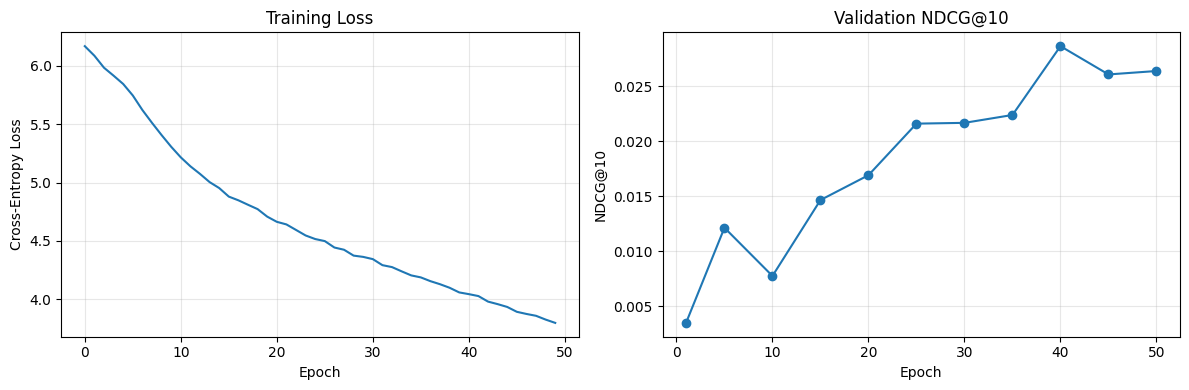

In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

eval_epochs = [1] + list(range(CONFIG['eval_every'], CONFIG['n_epochs']+1, CONFIG['eval_every']))
eval_epochs = eval_epochs[:len(history['val_ndcg'])]
axes[1].plot(eval_epochs, history['val_ndcg'], marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('Validation NDCG@10')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'lstm_training.png'), dpi=150)
plt.show()

## 8. Final Evaluation on Test Set

In [11]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lstm_best.pt')))

# Evaluate on test set
test_metrics = evaluate_model(model, user_sequences, test_targets, CONFIG['top_k'])

print("="*60)
print("FINAL TEST RESULTS - LSTM Sequential Recommender")
print("="*60)
for metric, value in sorted(test_metrics.items()):
    print(f"  {metric}: {value:.4f}")

FINAL TEST RESULTS - LSTM Sequential Recommender
  HR@10: 0.0308
  HR@20: 0.0504
  HR@5: 0.0112
  NDCG@10: 0.0137
  NDCG@20: 0.0184
  NDCG@5: 0.0075
  Precision@10: 0.0031
  Precision@20: 0.0025
  Precision@5: 0.0022
  Recall@10: 0.0308
  Recall@20: 0.0504
  Recall@5: 0.0112


## 9. Comparison with Matrix Factorization

In [12]:
# Load MF results for comparison
try:
    with open(os.path.join(CONFIG['results_dir'], 'mf_results.pkl'), 'rb') as f:
        mf_results = pickle.load(f)
    mf_metrics = mf_results['test_metrics']
    
    print("="*60)
    print("MODEL COMPARISON")
    print("="*60)
    print(f"{'Metric':<15} {'MF':>10} {'LSTM':>10} {'Diff':>10}")
    print("-"*45)
    
    for metric in sorted(test_metrics.keys()):
        mf_val = mf_metrics.get(metric, 0)
        lstm_val = test_metrics[metric]
        diff = lstm_val - mf_val
        sign = '+' if diff > 0 else ''
        print(f"{metric:<15} {mf_val:>10.4f} {lstm_val:>10.4f} {sign}{diff:>9.4f}")
except:
    print("MF results not found - run MF notebook first for comparison")

MODEL COMPARISON
Metric                  MF       LSTM       Diff
---------------------------------------------
HR@10               0.0084     0.0308 +   0.0224
HR@20               0.0224     0.0504 +   0.0280
HR@5                0.0028     0.0112 +   0.0084
NDCG@10             0.0030     0.0137 +   0.0106
NDCG@20             0.0067     0.0184 +   0.0117
NDCG@5              0.0014     0.0075 +   0.0061
Precision@10        0.0008     0.0031 +   0.0022
Precision@20        0.0011     0.0025 +   0.0014
Precision@5         0.0006     0.0022 +   0.0017
Recall@10           0.0084     0.0308 +   0.0224
Recall@20           0.0224     0.0504 +   0.0280
Recall@5            0.0028     0.0112 +   0.0084


In [13]:
# Save results
results = {
    'model': 'LSTMRecommender',
    'config': CONFIG,
    'best_epoch': best_epoch,
    'best_val_ndcg': best_ndcg,
    'test_metrics': test_metrics,
    'history': history
}

with open(os.path.join(CONFIG['results_dir'], 'lstm_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

with open(os.path.join(CONFIG['results_dir'], 'lstm_results.txt'), 'w') as f:
    f.write("LSTM Sequential Recommender Results\n")
    f.write("="*40 + "\n\n")
    f.write("Configuration:\n")
    for k, v in CONFIG.items():
        f.write(f"  {k}: {v}\n")
    f.write(f"\nBest Epoch: {best_epoch}\n")
    f.write(f"Best Validation NDCG@10: {best_ndcg:.4f}\n")
    f.write("\nTest Metrics:\n")
    for metric, value in sorted(test_metrics.items()):
        f.write(f"  {metric}: {value:.4f}\n")

print("Results saved!")

Results saved!


## Summary

LSTM Sequential Recommender implemented and trained!

**Key Features:**
- Multi-layer LSTM captures sequential patterns
- Handles variable-length sequences with padding
- Cross-entropy loss for next-item prediction

**Next Steps:**
- Implement BERT4Rec (Transformer-based)
- Implement LightGCN (Graph Neural Network)